# Comparison of Station Data and HRDPS
Summer only, along strait in the JDF - along strait direction chosen based upon Ben's direction analysis

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import math
from datetime import datetime
from calendar import monthrange
from matplotlib import pyplot as plt, colors
from windrose import WindroseAxes
from cmocean import cm as cmo
from tqdm.notebook import tqdm
from salishsea_tools import wind_tools, places, viz_tools
from scipy import interpolate

%matplotlib inline

In [2]:
#bring in data
racerocks = pd.read_csv("RaceRocks.csv").drop(['Temp (°C)','Stn Press (kPa)'],axis='columns')
sheringham = pd.read_csv("Sheringham.csv").drop(['Temp (°C)','Stn Press (kPa)'],axis='columns')
neah = pd.read_csv("neah.csv",header=0).drop(axis=0, index=0)
angeles =  pd.read_csv("PortAngeles.csv",header=0).drop(axis=0, index=0)

#sandheads is a bit of a different process
sandheads = pd.read_csv('SH_total_31Dec2020.dat', names=['Day', 'Month', 'Year', 'Hour', 'North/South', 'East/West'], sep='\s+')
sandheads['datetime'] = pd.to_datetime(sandheads.drop(columns=['North/South', 'East/West']))
sandheads = sandheads.drop(columns=['Day', 'Month', 'Year', 'Hour'])

/home/rbeutel/anaconda3/envs/eosc510/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/rbeutel/anaconda3/envs/eosc510/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
neah['WDIR']=pd.to_numeric(neah['WDIR'])
neah['WSPD']=pd.to_numeric(neah['WSPD'])

angeles['WDIR']=pd.to_numeric(angeles['WDIR'])
angeles['WSPD']=pd.to_numeric(angeles['WSPD'])

In [4]:
angeles.WDIR[(angeles.WDIR == 999)] = np.nan
angeles.WSPD[(angeles.WSPD == 99.0)] = np.nan

<ipython-input-4-c7880cccd3c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  angeles.WDIR[(angeles.WDIR == 999)] = np.nan
<ipython-input-4-c7880cccd3c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  angeles.WSPD[(angeles.WSPD == 99.0)] = np.nan


##### lets do some trimming before more preprocessing

In [5]:
e = min(max(neah['Date/Time']),max(angeles['Date/Time']), max(sheringham['Date/Time (LST)']), max(racerocks['Date/Time (LST)']))#, str(max(sandheads['datetime'])))
s = max(min(neah['Date/Time']),min(angeles['Date/Time']), min(sheringham['Date/Time (LST)']), min(racerocks['Date/Time (LST)']), str(min(sandheads['datetime'])))

start=datetime(int(s[:4]),int(s[5:7]),int(s[8:10]))
end =datetime(int(e[:4]),int(e[5:7]),int(e[8:10]))

time = pd.date_range(start,end)

In [6]:
racerocks['Date/Time (LST)']=pd.to_datetime(racerocks['Date/Time (LST)'])
sheringham['Date/Time (LST)']=pd.to_datetime(sheringham['Date/Time (LST)'])
neah['Date/Time']=pd.to_datetime(neah['Date/Time'])
angeles['Date/Time']=pd.to_datetime(angeles['Date/Time'])

#take daily average
RR_davg = racerocks.resample('D', on='Date/Time (LST)').mean()
SH_davg = sheringham.resample('D', on='Date/Time (LST)').mean()
PA_davg = angeles.resample('D', on='Date/Time').mean()
NB_davg = neah.resample('D', on='Date/Time').mean()
SA_davg = sandheads.resample('D', on='datetime').mean()

In [7]:
#trim data to be for same time extent as hrdps
RR_davg = RR_davg[start:end]
SH_davg = SH_davg[start:end]
PA_davg = PA_davg[start:end]
NB_davg = NB_davg[start:end]
SA_davg = SA_davg[start:end]

## Station Distance into the Salish Sea
Based on Ben's analysis (https://nbviewer.jupyter.org/github/UBC-MOAD/PythonNotes/blob/master/windrecipes.ipynb) decide on each station's distance into the JDF so that you can convert wind to along-axis wind for each of them (direction not consistent throughout the JDF)

In [9]:
# Load HRDPS record
HRDPS = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/HRDPS_1h_20141201_20200201_wind.nc')

# Define coordinate variables
longitude, latitude = [HRDPS[var].values for var in ('longitude', 'latitude')]
deg2m, coslat = 111e3, np.cos(np.deg2rad(50))

# Limit HRDPS mask to open water
mask_trimmed = np.copy(HRDPS.landmask.values)
mask_trimmed[20:40, 40:50] = 0 # Saanich Inlet
mask_trimmed[:, 72:] = 0       # Boundary Bay
mask_trimmed[40:, 61:] = 0     # Fraser River
mask_trimmed[58:, 53:] = 0     # Howe Sound
mask_trimmed[76:, 35:] = 0     # Jervis Inlet
mask_trimmed[100:, :] = 0      # Discovery Islands

# Define along-axis guides (x, y)
guides = {
    'west': [(2, 40), (40, 15), (45, 20), (45, 35), (18, 60), (0, 97)],
    'east': [(0, 15), (40, 0), (73, 0), (73, 45), (45, 75), (18, 106)],
}

In [10]:
# Find lon and lat at the midpoint of each cross-axis segment
lons, lats, midpoints = [], [], []
for segment in zip(*guides.values()):
    xy = [[xy[dim] for xy in segment] for dim in (0, 1)]
    midpoint = tuple(int((coord[1] - coord[0]) / 2 + coord[0]) for coord in xy)
    lon, lat = [coord[midpoint[::-1]] for coord in (longitude, latitude)]
    lons.append(lon), lats.append(lat), midpoints.append(midpoint)
#     ax.plot(*xy, 'b--')
#     ax.plot(*midpoint, 'bo')

# Define along-axis distance on the midpoints according to the lon and lat differences
distance = np.sqrt((np.diff(lons) * deg2m * coslat)**2 + (np.diff(lats) * deg2m)**2)
distance = list(np.insert(np.cumsum(distance), 0, 0))

# the following lists are in the order: [mouth, neah, sheringham, racerocks, port angeles, sandhead]
st_lat = [lats[0], 48.493, 48.281147, 48.23, 48.125, 49.10] #had to mess with the latitudes a bit to get the point in the middle of the strait
# st_lat = [lats[0], 48.493, sheringham["Latitude (y)"][0], racerocks["Latitude (y)"][0]]
st_lon = [lons[0], -124.726, sheringham["Longitude (x)"][0], racerocks["Longitude (x)"][0], -123.441, -123.30]

st_distance = np.sqrt((np.diff(st_lon) * deg2m * coslat)**2 + (np.diff(st_lat) * deg2m)**2)
st_distance = list(np.insert(np.cumsum(st_distance), 0, 0))
st_distance

[0.0,
 13922.698385907512,
 76052.52679718049,
 104452.06100786847,
 117724.69374294166,
 226416.2740742715]

In [11]:
# Interpolate distances onto HRDPS grid
guidepoints = [[], []]
for dim in (0, 1):
    for cst in guides:
        guidepoints[dim].extend([xy[dim] for xy in guides[cst]])
xi = tuple(np.meshgrid(*[np.arange(len(HRDPS[dim])) for dim in ('gridX', 'gridY')]))
distance_interp = interpolate.griddata(tuple(guidepoints), distance + distance, xi)

In [12]:
# Process wind
mask_flat = mask_trimmed.reshape(-1).astype('bool')
u, v = [HRDPS[var].values for var in ['u_wind', 'v_wind']]
dist = np.broadcast_to(distance_interp, u.shape)
dist, u, v = [var.reshape(-1, len(mask_flat))[:, mask_flat].flatten() for var in (dist, u, v)]
wspd = np.sqrt(u**2 + v**2)
wdir = np.rad2deg(np.arctan2(v, u)) - 90   # CCW from N
wdir[wdir < 0] = wdir[wdir < 0] + 360      # shift to 0-360

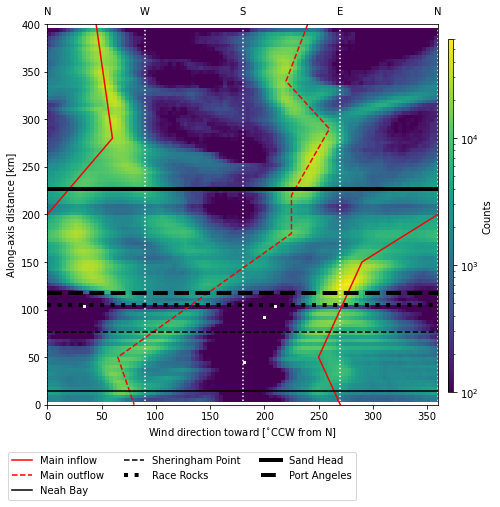

In [14]:
# Make plot area
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Plot wind direction vs along-axis distance, for wind speed > 5 m/s
_, _, _, c = ax.hist2d(wdir[wspd>5], 1e-3*dist[wspd>5], bins=100, norm=colors.LogNorm(vmin=1e2, vmax=6e4))

# Add grid lines
for x, label in zip(np.arange(0, 361, 90), ['N', 'W', 'S', 'E', 'N']):
    ax.plot([x, x], [0, 400], 'w:')
    ax.text(x, 410, label, ha='center')

# Trace dominant flow patterns
ax.plot([45, 60, 0, np.nan, 360, 290, 250, 270], [400, 280, 200, np.nan, 200, 150, 50, 0], 'r-', label='Main inflow')
ax.plot([240, 220, 260, 225, 225, 65, 80], [400, 340, 290, 220, 180, 50, 0], 'r--', label='Main outflow')
ax.plot([0, 360], [st_distance[1]/1000,st_distance[1]/1000], 'k-', label='Neah Bay')
ax.plot([0, 360], [st_distance[2]/1000,st_distance[2]/1000], 'k--', label='Sheringham Point')
ax.plot([0, 360], [st_distance[3]/1000,st_distance[3]/1000], 'k:', label='Race Rocks', linewidth='4')
ax.plot([0, 360], [st_distance[5]/1000,st_distance[5]/1000], 'k-', label='Sand Head', linewidth='4')
ax.plot([0, 360], [st_distance[4]/1000,st_distance[4]/1000], 'k--', label='Port Angeles', linewidth='4')

# Formatting
lims = [(0, 360, 0, 150)]
ticks = [(0, 361, 45, 0, 150, 50)]

ax.set_xlim(0,360)
ax.set_ylim(0,400)

# ax.xaxis.set_ticks(np.arange(*tick[:3]))
# ax.yaxis.set_ticks(np.arange(*tick[3:]))

ax.set_xlabel('Wind direction toward [$^{\circ}$CCW from N]')
ax.set_ylabel('Along-axis distance [km]')
ax.legend(loc=(-0.1, -0.25), ncol=3)
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax, label='Counts')

## Convert wind to along strait speed
Decide on 'along strait' wind direction for each station and convert their speeds using this value to along striat wind speed

In [8]:
#setting 'in' as the positive direction
direc_nb = 265
direc_sh = 270
direc_rr = 290 #race-rocks dominant direction not as clear
direc_pa = 295
direc_sa = 205

In [9]:
def along_axis_wind(speed,direc,axis_angle):
# this function calculates the wind speed relative to dominant the along-strait wind direction 
# and flips the data so the wind is written in way that oceanographers prefer (towards the __ instead of from the __)
    a = axis_angle - 270
    s_out = 0
    
    direc += a
    if direc > 360:
        direc -= 360
    elif direc < 0:
        direc += 360
    
    if direc>=0 and direc<90:
        b = math.radians(90-direc)
        s_out = math.cos(b)*speed
    elif direc>=90 and direc<180:
        b = math.radians(direc-90)
        s_out = math.cos(b)*speed
    elif direc>=180 and direc<270:
        b = math.radians(270-direc)
        s_out = -math.cos(b)*speed
    else:
        b = math.radians(direc-270)
        s_out = -math.cos(b)*speed
    
    return s_out

In [10]:
s_temp = np.zeros(len(NB_davg))

for i in range(len(NB_davg)):
    s_temp[i] = along_axis_wind(NB_davg.WSPD[i],NB_davg.WDIR[i],direc_nb)

NB_davg['axisSPD'] = s_temp

In [11]:
s_temp = np.zeros(len(SH_davg))

for i in range(len(SH_davg)):
    s_temp[i] = along_axis_wind(SH_davg['Wind Spd (km/h)'][i]*1000*(1/3600),SH_davg['Wind Dir (10s deg)'][i]*10,direc_sh)

SH_davg['axisSPD'] = s_temp

In [12]:
s_temp = np.zeros(len(RR_davg))

for i in range(len(RR_davg)):
    s_temp[i] = along_axis_wind(RR_davg['Wind Spd (km/h)'][i]*1000*(1/3600),RR_davg['Wind Dir (10s deg)'][i]*10,direc_rr)

RR_davg['axisSPD'] = s_temp

In [13]:
s_temp = np.zeros(len(NB_davg))

for i in range(len(PA_davg)):
    s_temp[i] = along_axis_wind(PA_davg.WSPD[i],PA_davg.WDIR[i],direc_pa)

PA_davg['axisSPD'] = s_temp

In [14]:
SA_davg['WSPD'] = np.sqrt(np.add(np.square(SA_davg['North/South']),np.square(SA_davg['East/West'])))
SA_davg['WDIR'] = [math.degrees(np.arctan2(SA_davg['North/South'][i],SA_davg['East/West'][i])) for i in range(len(SA_davg))]

s_sa = np.zeros(len(SA_davg))

for i in range(len(SA_davg)):
    s_sa[i] = along_axis_wind(SA_davg['WSPD'][i],SA_davg['WDIR'][i],direc_sa)

SA_davg['axisSPD'] = s_sa

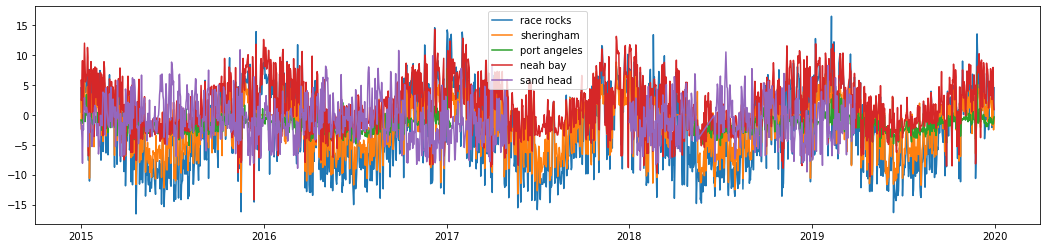

In [15]:
#plot the wind data at all stations again
plt.figure(figsize=(18,4))
plt.plot(RR_davg['axisSPD'],label='race rocks')
plt.plot(SH_davg['axisSPD'],label='sheringham')
plt.plot(PA_davg['axisSPD'],label='port angeles')
plt.plot(NB_davg['axisSPD'],label='neah bay')
plt.plot(SA_davg['axisSPD'], label='sand head')
plt.legend()

### Bring in HRDPS

In [16]:
hrdps = xr.open_dataset("hrdps_day_avgs_postSep2014.nc")
hrdps_lat = pd.read_csv('hrdps_lat.csv',header=None)[0].to_numpy()
hrdps_lon = pd.read_csv('hrdps_lon.csv',header=None)[0].to_numpy()

In [17]:
hrdps = hrdps.sel(time_counter=slice(s[:10]+'T00:00:00.000000000', e[:10]+'T00:00:00.000000000'))

In [18]:
u= hrdps.u_wind.values
v = hrdps.v_wind.values
speed_temp = np.sqrt(np.add(np.square(u),np.square(v)))
direc_temp = np.arctan2(u,v)

In [19]:
#get into shape we can work with
speed_hrdps = np.empty((np.shape(speed_temp)[1]*np.shape(speed_temp)[2],np.shape(speed_temp)[0]))
for i in range(np.shape(speed_temp)[0]):
    speed_hrdps[:,i] = np.reshape(speed_temp[i],(np.shape(speed_temp)[1]*np.shape(speed_temp)[2],))
    
direc_hrdps = np.empty((np.shape(direc_temp)[1]*np.shape(direc_temp)[2],np.shape(direc_temp)[0]))
for i in range(np.shape(direc_temp)[0]):
    direc_hrdps[:,i] = np.reshape(direc_temp[i],(np.shape(direc_temp)[1]*np.shape(direc_temp)[2],))

## Compare HRDPS to station data

In [20]:
#want to isolate HRDPS data from nav_lat and nav_lon close to each station
def find_nearest(lons, lats, station_lon, station_lat):
    buffer = np.linspace(0.1,0.00001,50)
    ind = []
    
    for b in buffer:
        for i in range(len(lons)):
            if lons[i] > (station_lon-b) and lons[i] < (station_lon+b) and lats[i] > (station_lat-b) and lats[i] < (station_lat+b):
                ind.append(i)
        if len(ind) == 1:
            break
        else:
            ind = []
    
    return ind

#### Race Rocks

In [21]:
ind_RR = find_nearest(hrdps_lon, hrdps_lat, racerocks['Longitude (x)'][0]+360, racerocks['Latitude (y)'][0])
print('HRDPS closest lat= '+str(hrdps_lat[ind_RR])+', closest lon= '+str(hrdps_lon[ind_RR]))

HRDPS closest lat= [48.29035765], closest lon= [236.46529316]


In [22]:
#trim HRDPS so that its just the index we care about 
speed_hrdps_rr=speed_hrdps[ind_RR,:][0]
direc_hrdps_rr=direc_hrdps[ind_RR,:][0]

#convert to along-axis speed
s_rr = np.zeros(len(speed_hrdps_rr))

for i in range(len(speed_hrdps_rr)):
    s_rr[i] = along_axis_wind(speed_hrdps_rr[i],math.degrees(direc_hrdps_rr[i]*10),direc_rr)

axSPD_hrdps_rr = s_rr 

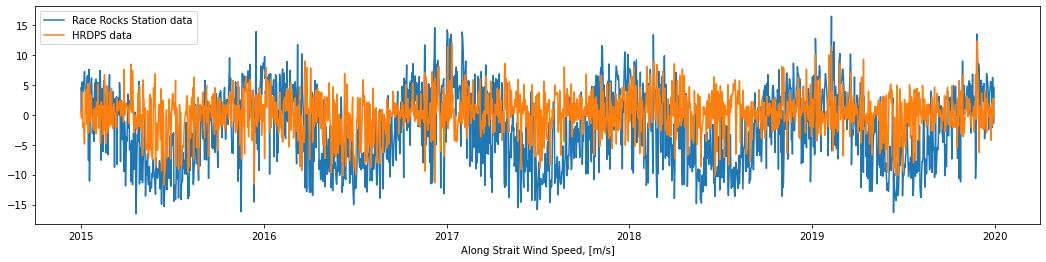

In [23]:
#plot comparison to racerocks
plt.figure(figsize=(18,4))
plt.plot(time,RR_davg['axisSPD'],label='Race Rocks Station data')
plt.plot(time,axSPD_hrdps_rr, label='HRDPS data')
plt.xlabel('Along Strait Wind Speed, [m/s]')
plt.legend()

#### Sheringham

In [24]:
ind_SH = find_nearest(hrdps_lon, hrdps_lat, sheringham['Longitude (x)'][0]+360, sheringham['Latitude (y)'][0])
print('HRDPS closest lat= '+str(hrdps_lat[ind_SH])+', closest lon= '+str(hrdps_lon[ind_SH]))

HRDPS closest lat= [48.37136105], closest lon= [236.08777422]


In [25]:
#trim HRDPS and convert to along-axis speed
s_sh = np.zeros(len(speed_hrdps[ind_SH,:][0]))

for i in range(len(s_sh)):
    s_sh[i] = along_axis_wind(speed_hrdps[ind_SH,:][0][i],math.degrees(direc_hrdps[ind_SH,:][0][i]*10),direc_sh)

axSPD_hrdps_sh = s_sh 

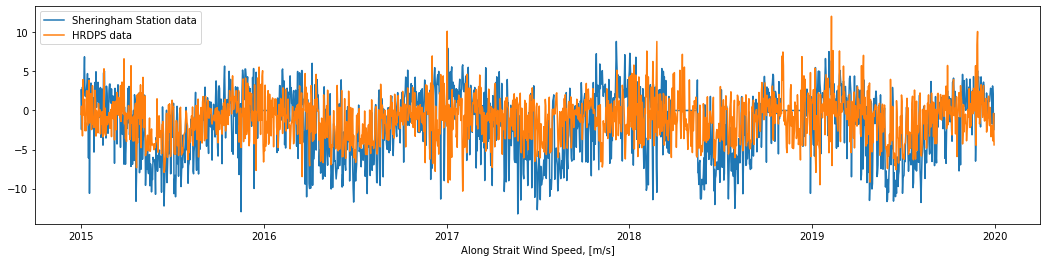

In [26]:
#plot comparison to sheringham
plt.figure(figsize=(18,4))
plt.plot(time,SH_davg['axisSPD'],label='Sheringham Station data')
plt.plot(time,axSPD_hrdps_sh, label='HRDPS data')
plt.xlabel('Along Strait Wind Speed, [m/s]')
plt.legend()

#### Neah Bay

In [27]:
ind_NB = find_nearest(hrdps_lon, hrdps_lat, -124.726+360, 48.493)
print('HRDPS closest lat= '+str(hrdps_lat[ind_NB])+', closest lon= '+str(hrdps_lon[ind_NB]))

HRDPS closest lat= [48.49932174], closest lon= [235.27212539]


In [28]:
#trim HRDPS and convert to along-axis speed
s_nb = np.zeros(len(speed_hrdps[ind_NB,:][0]))

for i in range(len(s_nb)):
    s_nb[i] = along_axis_wind(speed_hrdps[ind_NB,:][0][i],math.degrees(direc_hrdps[ind_NB,:][0][i]*10),direc_nb)

axSPD_hrdps_nb = s_nb 

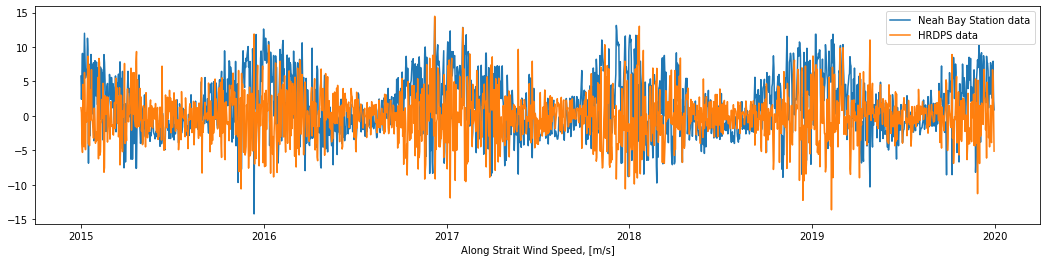

In [29]:
#plot comparison to neah bay
plt.figure(figsize=(18,4))
plt.plot(time,NB_davg['axisSPD'],label='Neah Bay Station data')
plt.plot(time,axSPD_hrdps_nb, label='HRDPS data')
plt.xlabel('Along Strait Wind Speed, [m/s]')
plt.legend()

#### Port Angeles

In [30]:
ind_PA = find_nearest(hrdps_lon, hrdps_lat, -123.441+360, 48.125)
print('HRDPS closest lat= '+str(hrdps_lat[ind_PA])+', closest lon= '+str(hrdps_lon[ind_PA]))

HRDPS closest lat= [48.13256462], closest lon= [236.57328922]


In [31]:
#trim HRDPS and convert to along-axis speed
s_ = np.zeros(len(speed_hrdps[ind_PA,:][0]))

for i in range(len(s_)):
    s_[i] = along_axis_wind(speed_hrdps[ind_PA,:][0][i],math.degrees(direc_hrdps[ind_PA,:][0][i]*10),direc_pa)

axSPD_hrdps_pa = s_

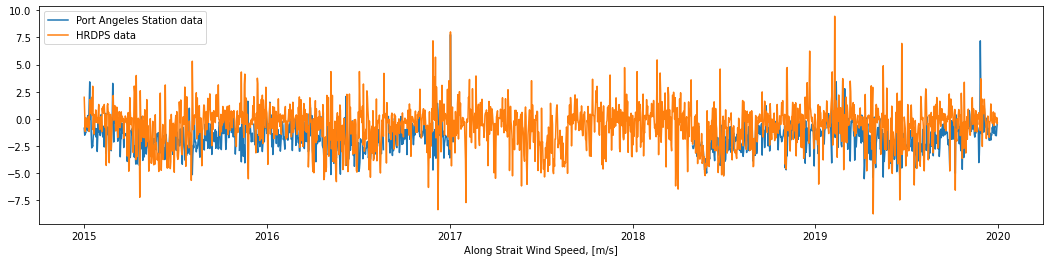

In [32]:
#plot comparison to port angeles
plt.figure(figsize=(18,4))
plt.plot(time,PA_davg['axisSPD'],label='Port Angeles Station data')
plt.plot(time,axSPD_hrdps_pa, label='HRDPS data')
plt.xlabel('Along Strait Wind Speed, [m/s]')
plt.legend()

#### Sand Heads

In [33]:
ind_SA = find_nearest(hrdps_lon, hrdps_lat, -123.30+360, 49.10)
print('HRDPS closest lat= '+str(hrdps_lat[ind_SA])+', closest lon= '+str(hrdps_lon[ind_SA]))

HRDPS closest lat= [49.09078484], closest lon= [236.69729251]


In [34]:
#trim HRDPS and convert to along-axis speed
s_ = np.zeros(len(speed_hrdps[ind_SA,:][0]))

for i in range(len(s_nb)):
    s_[i] = along_axis_wind(speed_hrdps[ind_SA,:][0][i],math.degrees(direc_hrdps[ind_SA,:][0][i]*10),direc_sa)

axSPD_hrdps_sa = s_ 

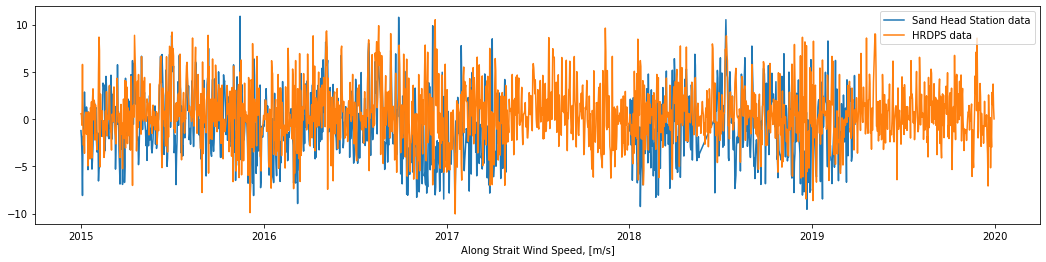

In [35]:
#plot comparison to neah bay
plt.figure(figsize=(18,4))
plt.plot(SA_davg['axisSPD'],label='Sand Head Station data')
plt.plot(time,axSPD_hrdps_sa, label='HRDPS data')
plt.xlabel('Along Strait Wind Speed, [m/s]')
plt.legend()

### Lets look at just the summers
plot each year seperately

In [36]:
def plot_summers(year):
    start = np.where(time == np.datetime64(datetime(year, 5, 1)))[0][0]
    end = np.where(time == np.datetime64(datetime(year, 9, 30)))[0][0]
    Stime = pd.date_range(np.datetime64(datetime(year, 5, 1)),np.datetime64(datetime(year, 9, 30)))
    
    #trim data to be for same time extent as hrdps
    RR_davgS = RR_davg[start:end+1]
    hrdps_rrS = axSPD_hrdps_rr[start:end+1]

    SH_davgS = SH_davg[start:end+1]
    hrdps_shS = axSPD_hrdps_sh[start:end+1]

    NB_davgS = NB_davg[start:end+1]
    hrdps_nbS = axSPD_hrdps_nb[start:end+1]
    
    PA_davgS = PA_davg[start:end+1]
    hrdps_paS = axSPD_hrdps_pa[start:end+1]
    
    SA_davgS = SA_davg[start:end+1]
    hrdps_saS = axSPD_hrdps_sa[start:end+1]
    
    #now plot!
    zero = np.zeros(len(Stime))
    ticks = ['June', 'July', 'August', 'September']
    location = [datetime(year,6,1),datetime(year,7,1),datetime(year,8,1),datetime(year,9,1)]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].plot(Stime,NB_davgS['axisSPD'],label='Neah Bay Station data')
    axs[0].plot(Stime,hrdps_nbS, label='Neah Bay HRDPS data')
    axs[0].plot(Stime,zero,'k--', alpha=0.5)
    axs[0].set_xlim(Stime[0], Stime[-1])
    axs[0].set_ylim(-9,9)
    axs[0].set_xticks(location)
    axs[0].set_xticklabels(ticks)
    axs[0].set_ylabel('Along Strait Wind Speed, [m/s]', fontsize=12)
    r = round(np.corrcoef(NB_davgS['axisSPD'],hrdps_nbS)[1][0],3)
    avg_diff = round(sum([NB_davgS['axisSPD'][i]-hrdps_nbS[i] for i in range(len(Stime))])/len(Stime),3)
    axs[0].set_title('r = '+str(r)+'\naverage difference = '+str(avg_diff))
    axs[0].legend()
    
    axs[1].plot(Stime,SH_davgS['axisSPD'],label='Sheringham Station data')
    axs[1].plot(Stime,hrdps_shS, label='Sheringham HRDPS data')
    axs[1].plot(Stime,zero,'k--', alpha=0.5)
    axs[1].set_xlim(Stime[0], Stime[-1])
    axs[1].set_ylim(-13,13)
    axs[1].set_xticks(location)
    axs[1].set_xticklabels(ticks)
    r = round(np.corrcoef(SH_davgS['axisSPD'],hrdps_shS)[1][0],3)
    avg_diff = round(sum([SH_davgS['axisSPD'][i]-hrdps_shS[i] for i in range(len(Stime))])/len(Stime),3)
    axs[1].set_title('r = '+str(r)+'\naverage difference = '+str(avg_diff))
    axs[1].legend()
  
    axs[2].plot(Stime,RR_davgS['axisSPD'],label='Race Rocks Station data')
    axs[2].plot(Stime,hrdps_rrS, label='Race Rocks HRDPS data')
    axs[2].plot(Stime,zero,'k--', alpha=0.5)
    axs[2].set_xlim(Stime[0], Stime[-1])
    axs[2].set_ylim(-15,15)
    axs[2].set_xticks(location)
    axs[2].set_xticklabels(ticks)
    r = round(np.corrcoef(RR_davgS['axisSPD'],hrdps_rrS)[1][0],3)
    avg_diff = round(sum([RR_davgS['axisSPD'][i]-hrdps_rrS[i] for i in range(len(Stime))])/len(Stime),3)
    axs[2].set_title('r = '+str(r)+'\naverage difference = '+str(avg_diff))
    axs[2].legend()

  
    if year <2017 or year == 2018: #2015, 2016 and (kinda) 2018 are the years good for both sandhead and port angeles
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        
        axs[0].plot(Stime,PA_davgS['axisSPD'],label='Port Angeles Station data')
        axs[0].plot(Stime,hrdps_paS, label='Port Angeles HRDPS data')
        axs[0].plot(Stime,zero,'k--', alpha=0.5)
        axs[0].set_xlim(Stime[0], Stime[-1])
        axs[0].set_ylim(-13,13)
        axs[0].set_xticks(location)
        axs[0].set_xticklabels(ticks)
        r = round(np.corrcoef(PA_davgS['axisSPD'],hrdps_paS)[1][0],3)
        avg_diff = round(sum([PA_davgS['axisSPD'][i]-hrdps_paS[i] for i in range(len(Stime))])/len(Stime),3)
        axs[0].set_title('r = '+str(r)+'\naverage difference = '+str(avg_diff))
        axs[0].legend()
    
        axs[1].plot(Stime,SA_davgS['axisSPD'],label='Sand Head Station data')
        axs[1].plot(Stime,hrdps_saS, label='Sand Head HRDPS data')
        axs[1].plot(Stime,zero,'k--', alpha=0.5)
        axs[1].set_xlim(Stime[0], Stime[-1])
        axs[1].set_ylim(-13,13)
        axs[1].set_xticks(location)
        axs[1].set_xticklabels(ticks)
        r = round(np.corrcoef(SA_davgS['axisSPD'],hrdps_saS)[1][0],3)
        avg_diff = round(sum([SA_davgS['axisSPD'][i]-hrdps_saS[i] for i in range(len(Stime))])/len(Stime),3)
        axs[1].set_title('r = '+str(r)+'\naverage difference = '+str(avg_diff))
        axs[1].legend()
    
    if year == 2019: #2019 is good for port angeles
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        
        ax.plot(Stime,PA_davgS['axisSPD'],label='Port Angeles Station data')
        ax.plot(Stime,hrdps_paS, label='Port Angeles HRDPS data')
        ax.plot(Stime,zero,'k--', alpha=0.5)
        ax.set_xlim(Stime[0], Stime[-1])
        ax.set_ylim(-13,13)
        ax.set_xticks(location)
        ax.set_xticklabels(ticks)
        r = round(np.corrcoef(PA_davgS['axisSPD'],hrdps_paS)[1][0],3)
        avg_diff = round(sum([PA_davgS['axisSPD'][i]-hrdps_paS[i] for i in range(len(Stime))])/len(Stime),3)
        ax.set_title('r = '+str(r)+'\naverage difference = '+str(avg_diff))
        ax.legend()

##### NOTE: stations plotted in order from closest to the mouth to furthest

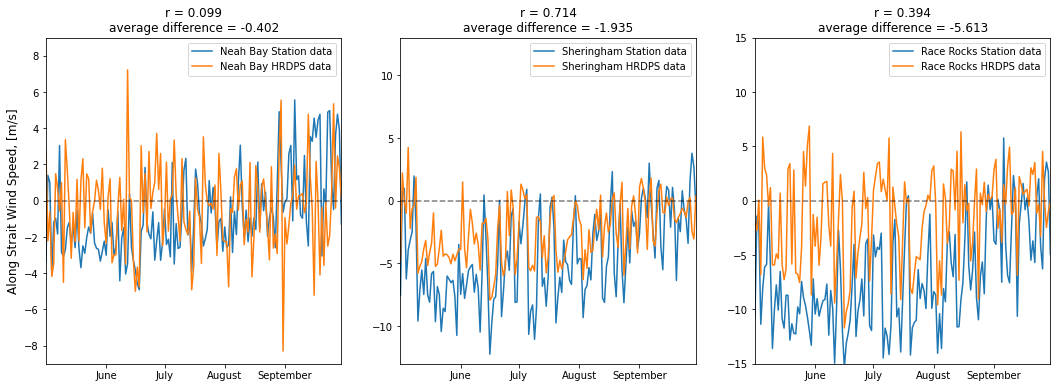

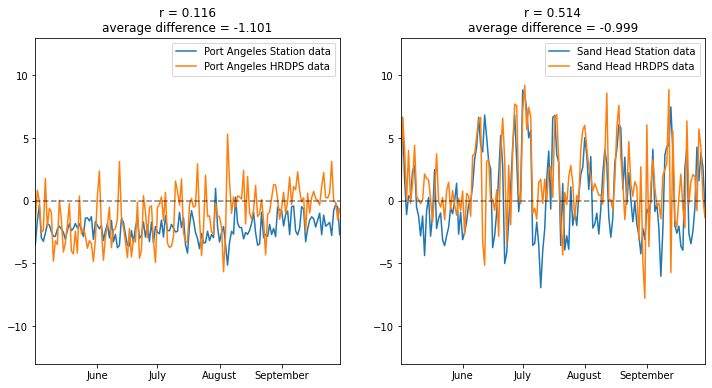

In [37]:
plot_summers(2015)

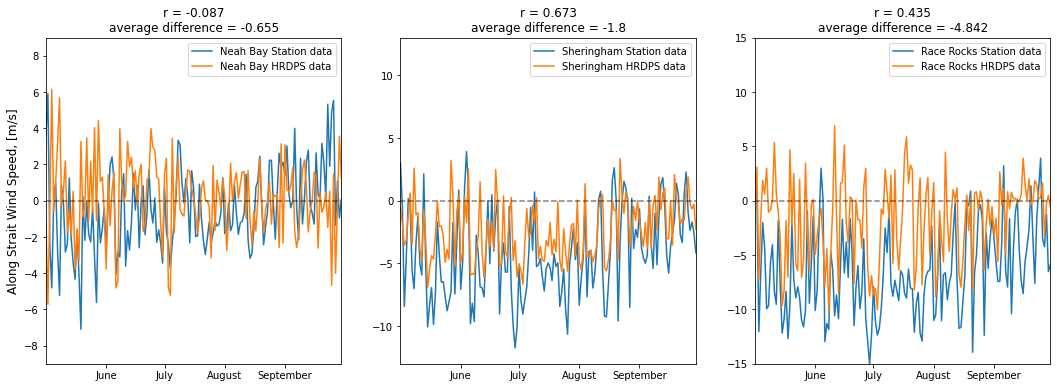

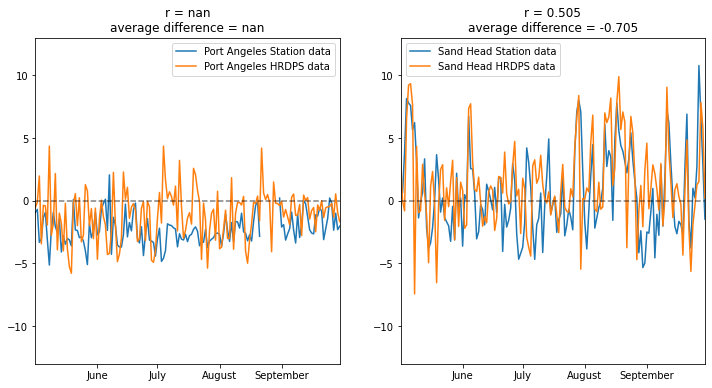

In [38]:
plot_summers(2016)

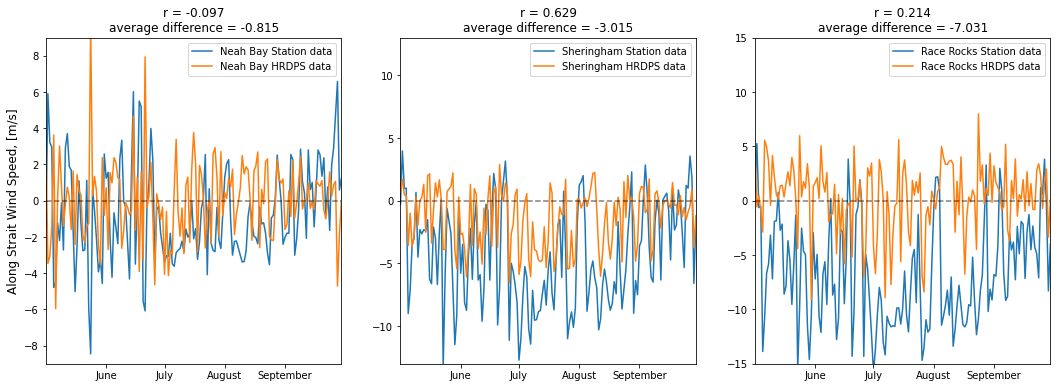

In [39]:
plot_summers(2017)

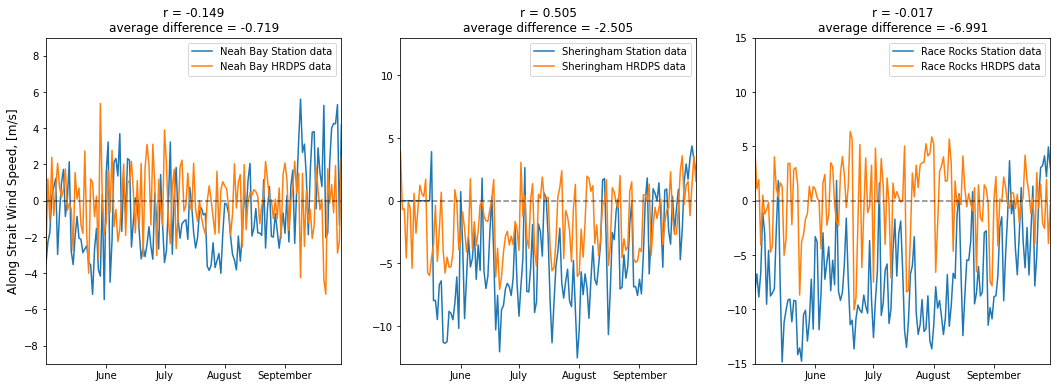

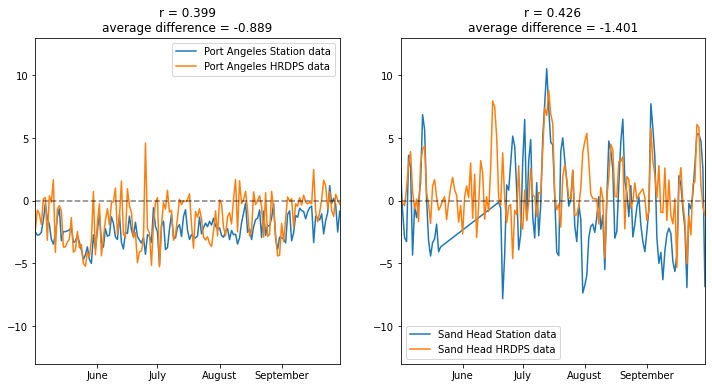

In [40]:
plot_summers(2018)

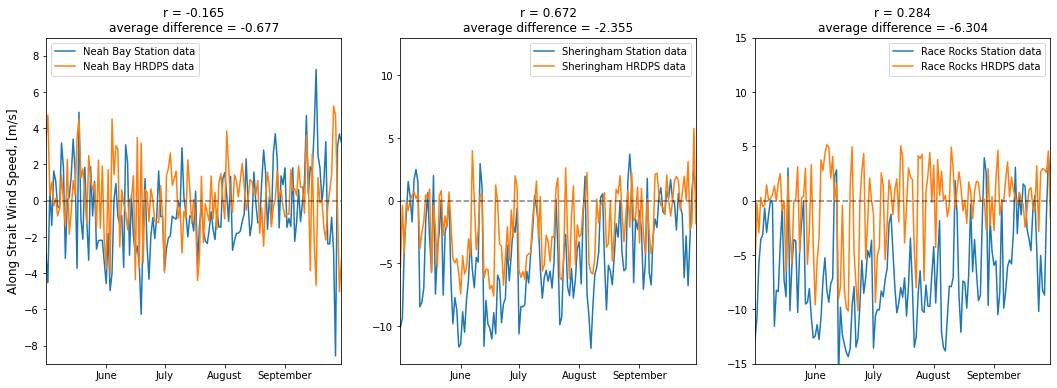

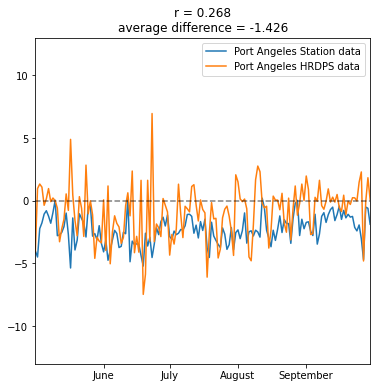

In [41]:
plot_summers(2019)